In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame,merge
%pylab inline
np.random.seed(127)

Populating the interactive namespace from numpy and matplotlib


In [353]:
animals = pd.read_csv("train.csv.gz", compression='gzip')
animals.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


### How OutcomeType affected by AnimalType and SexuponOutcome
Our target column is "OutcomeType". First we are interested to see how the "AnimalType" and "SexuponOutcome" attributes affect an animals outcome.

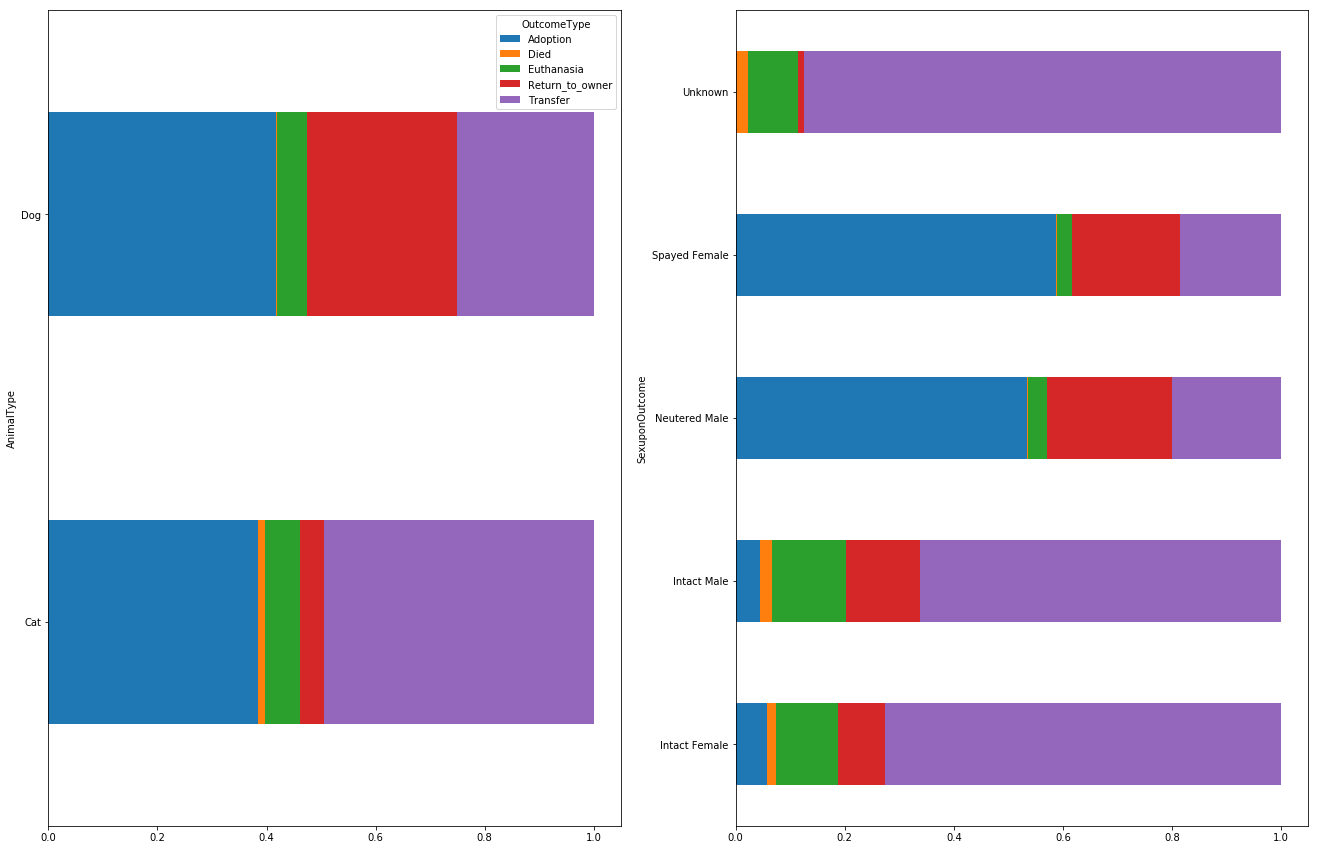

In [351]:
f, axs = plt.subplots(ncols=2)
figsize(20,5)
plt.subplots_adjust(right=1)
df1 = animals.groupby("AnimalType").OutcomeType.value_counts(normalize=True).unstack()
df1.plot(kind="barh", stacked=True, ax=axs[0])
df2 = animals.groupby("SexuponOutcome").OutcomeType.value_counts(normalize=True).unstack()
df2.plot(kind="barh", stacked=True, ax=axs[1], legend=False)

We have several findings here:
* Both dogs and cats has a low "Euthanasia" and "Died" rate, good news.
* Dogs are significantly more likely to be "Return_to_owner" than cats.
* Dogs are more likely to be in "returned_to_owner" than cats but cats has a higher "Transfer" rate
* Intact + unknown animals are more likely to be transfered. If we want to increase adoption rate, we should get animals neutered.
* This "unknown" group never gets adopted.

So far we don't know what other information we can draw from these features, we'll leave them as is.

In [413]:
# categorical feature "type"
typedict = {"Dog": 0, "Cat":1}

animals["type"] = animals["AnimalType"].map(typedict)

## Explore NULL values

In [97]:
for att in animals.columns:
    nums = animals[att].isnull().value_counts().as_matrix()
    if (len(nums) != 1):
        print "Feature \"{}\" has {} missing values".format(att, nums[-1])

Feature "Name" has 7691 missing values
Feature "OutcomeSubtype" has 13117 missing values
Feature "SexuponOutcome" has 1 missing values
Feature "AgeuponOutcome" has 18 missing values


First, we want to know the columns that has `np.nan` values and the number of `np.nan`s

### Name NULL values

Name might not seem like the first feature that matters when it comes to the outcome of an animal.However, having a name or not might affect the outcome of an animal, let's try it out.

In [286]:
# one interesting finding is that all animals that are named 'X' are transfered. We reason this might be the 
# another internal way of addressing an animal when transferring it without knowing its name. But it could also 
# be a second way they record if an animal has no name.
print "When Name is X, outcome of this animal is {}".format(animals[animals.Name == 'X'].OutcomeType.unique())

When Name is X, outcome of this animal is ['Transfer']


In [439]:
# we map nan and 'X' as '0' meaning no name, everything else has name
animals['HasName'] = animals.Name.map(lambda x : 0 if x == 'X' else 1, na_action='ignore')
animals['HasName'].fillna(value=0, inplace=True)

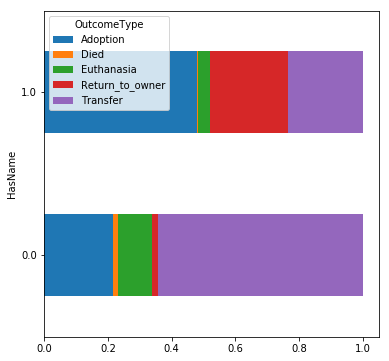

In [350]:
df = animals.groupby("HasName").OutcomeType.value_counts(normalize=True).unstack()
df.plot(kind="barh", stacked=True, figsize=(6,6))

### DateTime Features
We would like to add additional features indicating timeofday, weekofyear, etc for each DateTime value

In [403]:
# we already know that "DateTime" column does not have null values
animals['Timestamps'] = pd.to_datetime(animals['DateTime'])

print "Our records are between the range {} to {}".format(animals.Timestamps.min(), animals.Timestamps.max())

Our records are between the range 2013-10-01 09:31:00 to 2016-02-21 19:17:00


In [379]:
# we convert timestamps to several potential groups
animals['Year'] = animals.Timestamps.dt.year
animals['Month'] = animals.Timestamps.dt.month
animals['Weekday'] = animals.Timestamps.dt.weekday
animals['Hour'] = animals.Timestamps.dt.hour
animals['WeekofYear'] = animals.Timestamps.dt.weekofyear

In [397]:
def plot_datetime_features(feature):
    f, axs = plt.subplots(ncols=2)
    figsize(20,5)
    animals.groupby(feature).OutcomeType.value_counts(normalize=True).unstack().plot(kind="bar", stacked=True, ax=axs[0])
    animals.groupby(feature).OutcomeType.value_counts().unstack().plot(kind="bar", stacked=True, ax=axs[1])

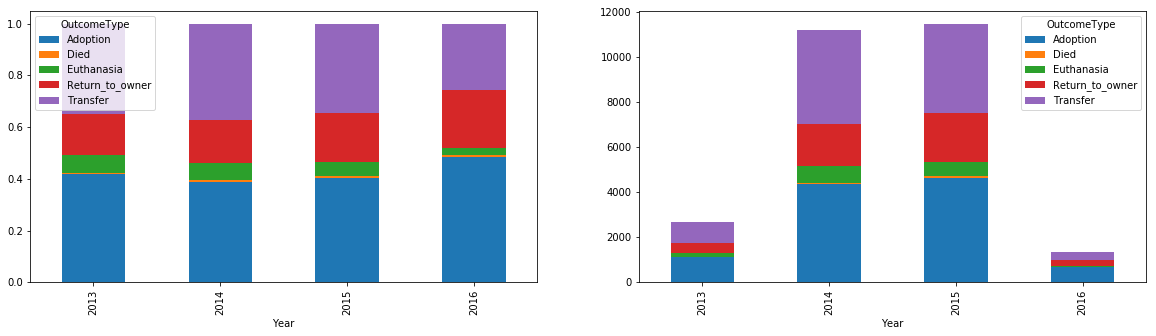

In [398]:
plot_datetime_features("Year")

Year does not seem to be an important feature as percentage-wise it does not affect animal outcome very much with the exception of 2016. However, since we have a lot less samples in 2016, the percentage advantage of later year is hard to infer.

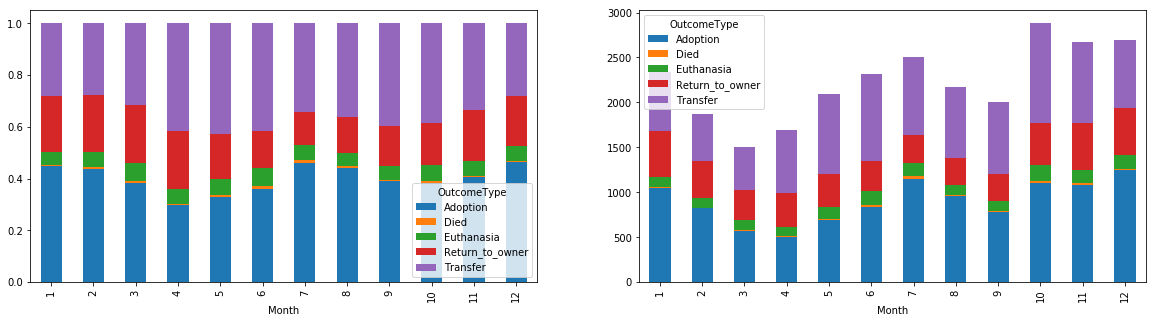

In [400]:
plot_datetime_features("Month")

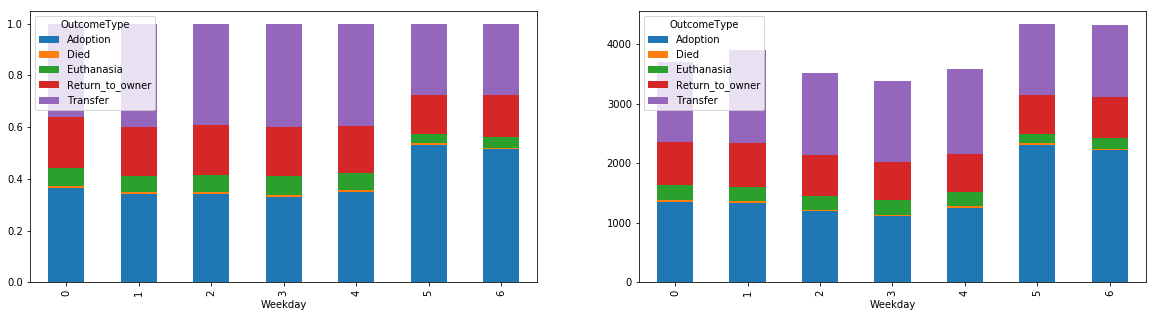

In [404]:
plot_datetime_features("Weekday")

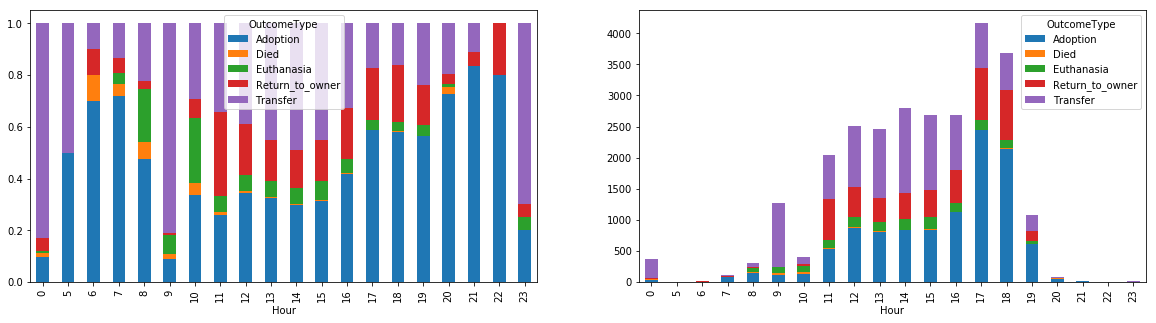

In [405]:
plot_datetime_features("Hour")

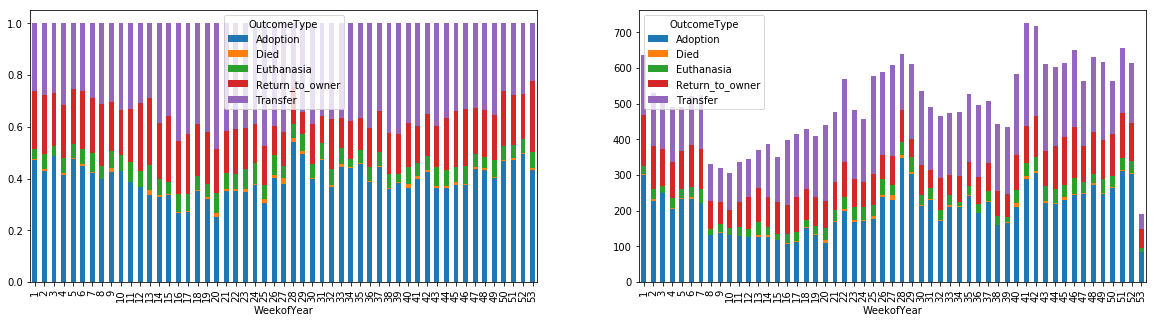

In [406]:
plot_datetime_features("WeekofYear")

## TODO: ISHOLIDAY

#### SexuponOutcome NULL and Unknown values

In [415]:
animals[animals.SexuponOutcome.isnull()]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Timestamps,Hour,Weekday,Month,WeekofYear,Year,type
3174,A667395,Diego,2013-11-27 16:11:00,Return_to_owner,NaN,Dog,NaN,7 years,Dachshund,Brown Merle,2013-11-27 16:11:00,16,2,11,48,2013,0


In [420]:
animals[(animals.AgeuponOutcome=="7 years") & (animals.AnimalType=="Dog")].SexuponOutcome.value_counts()

Neutered Male    200
Spayed Female    167
Intact Male       26
Intact Female     18
Name: SexuponOutcome, dtype: int64

In [422]:
# Given its name, and the fact that most male dogs around 7 years old are neutered, I'm guessing its a neutered male
animals.loc[3174, "SexuponOutcome"] = "Neutered Male"

As was shown before, "Unknown" sex has a disticntive distribution of outcome compared with other sex, we decide to
leave it as is. We could try [different encoding schemes](http://contrib.scikit-learn.org/categorical-encoding/) and see which one works the best on our project.

In [445]:
animals[animals.SexuponOutcome=='Unknown']

1093

In [434]:
import category_encoders as ce

In [435]:
encoder = ce.BackwardDifferenceEncoder(cols=["SexuponOutcome"])

In [670]:
# transforming sex info
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(animals["ImputedSex"])

animals["TransformedSex"] = le.transform(animals["ImputedSex"])

So I'm planning to impute all these randomly with the top two sex within age range (0 days - 2month) Or I should scale it idk.

In [606]:
df = animals[all((animals["SexuponOutcome"] != "Unknown", 
             animals["AnimalType"]=="Cat", 
             animals["AgeinDays"] < 30), 
            axis=0)]

In [632]:
dog_df["SexuponOutcome"].value_counts()

Intact Male      53
Intact Female    49
Name: SexuponOutcome, dtype: int64

In [635]:
from scipy.stats import bernoulli

In [636]:
bernoulli.rvs(p, size=1)

array([1])

In [611]:
vc = df["SexuponOutcome"].value_counts()

In [621]:
im_prob = vc["Intact Male"] / float(744+642+1)

In [622]:
from scipy.stats import bernoulli

In [645]:
blah = bernoulli.rvs(im_prob, size=10000)

In [668]:
def unknown_sex(sexstring):
    if sexstring == "Unknown":
        sex = bernoulli.rvs(im_prob)
        if sex == 1:
            return "Intact Male"
        else:
            return "Intact Female"
    else:
        return sexstring

In [669]:
animals["ImputatedSex"] = animals["SexuponOutcome"].apply(unknown_sex)

### "AgeuponOutcome" 
First we need to use the same unit on AgeuponOutcome feature. We decide to convert all of them into days. Note that some animals has an ange of "0 years"

In [447]:
animals.AgeuponOutcome.unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years', nan,
       '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [500]:
units = {"year" : 365, "month":31, "day":1, "week":7}

def get_age_in_days(agestring):
    age = 0
    for unit in units.keys():
        if (agestring.find(unit) != -1):
            age += int(agestring.split(" ")[0]) * units[unit]
    return age

In [505]:
animals["AgeinDays"] = animals.AgeuponOutcome.map(get_age_in_days, na_action="ignore")

Also it might be a good idea to have infant, child,  young adult, adult and old groups

## Engineering features

In [441]:
import holidays

In [442]:
from dateutil.relativedelta import relativedelta
from datetime import date
class MyHolidays(holidays.UnitedStates):
    def _populate(self, year):
        # Populate the holiday list with the default US holidays
        holidays.UnitedStates._populate(self, year)
        # Remove Columbus Day
        # self.pop(date(year, 10, 1) + relativedelta(weekday=MO(+2)), None)
        # Add Valentines Day
        self[date(year, 2, 14)] = "Valentines Day"
        self[date(year, 1, 1) + relativedelta(weekday=MO(+3))] = "Martin Luther King Day"
        self[date(year, 2, 1) + relativedelta(weekday=MO(+3))] = "President's Day"
        self[date(year, 5, 1) + relativedelta(weekday=SU(+2))] = "Mother's Day"
        self[date(year, 6, 1) + relativedelta(weekday=SU(+3))] = "Father's Day"
        self[date(year, 10, 31)] = "Halloween"

In [449]:
def is_holiday(t):
    tx_holidays = MyHolidays(state="TX", years =[2015])
    dt = datetime.datetime.strptime(t, r"%Y-%m-%d %H:%M:%S")
    if (dt.month in [1,6,7,8]) or (dt.date() in tx_holidays) or dt.weekday() in [5,6,0]:
        return True
    return False

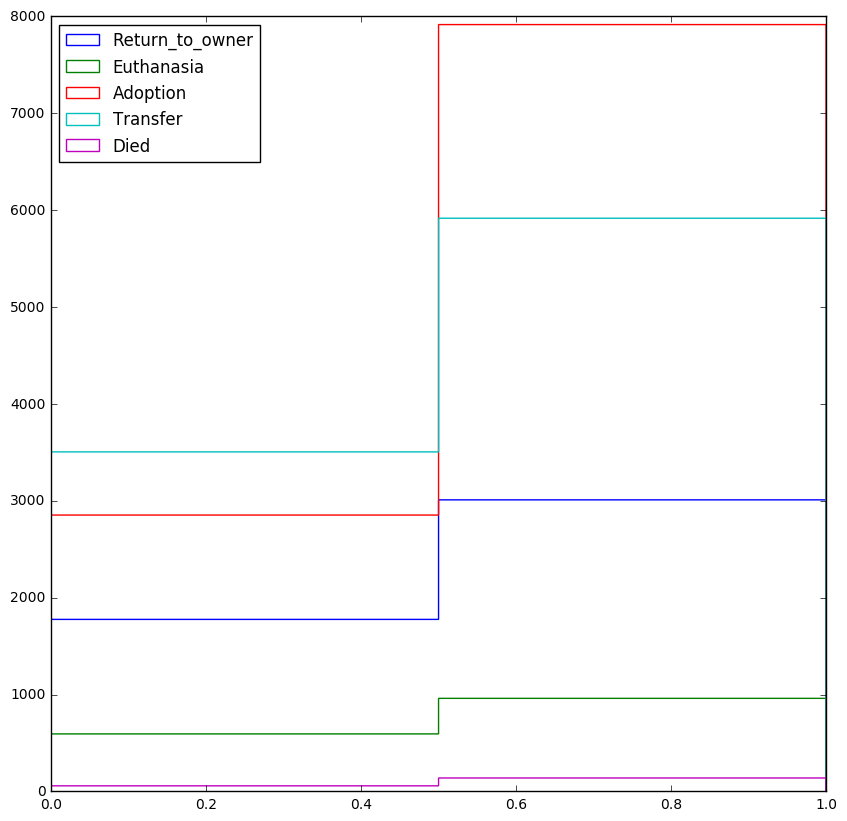

In [452]:
animals["isHoliday"] = animals["DateTime"].apply(is_holiday)

get_step_graph("isHoliday", 2)

### We might need weather too. I'm just leaving it here

### Getting breed information

In [511]:
dog_names = animals[animals['AnimalType']=="Dog"]['Breed'].tolist()

In [512]:
breeds = []
for breed in dog_names:
    tokens = breed.split("/")
    for b in tokens:
        if "Mix" in b:
            b = b.replace(" Mix", "")
        breeds.append(b)

In [513]:
breeds = unique(breeds).tolist()
print len(breeds)

191


[This](http://www.animalplanet.com/breed-selector/dog-breeds/all-breeds-akc-group.html) website has all breed infomation. 

In [552]:
herding_dogs = ['Australian Cattle Dog', 'Australian Shepherd', 'Bearded Collie', 'Beauceron', 'Belgian Malinois', 
          'Belgian Sheepdog', 'Belgian Tervuren', 'Border Collie', 'Bouvier des Flandres', 'Briard', 'Canaan Dog',
          'Cardigan Welsh Corgi', 'Collie', 'German Shepherd Dog', 'Old English Sheepdog', 'Pembroke Welsh Corgi',
          'Polish Lowland Sheepdog', 'Puli', 'Shetland Sheepdog']

In [553]:
hound_dogs = ['Afghan Hound', 'American Foxhound', 'Basenji', 'Basset Hound', 'Beagle', 'Black and Tan Coonhound',
              'Bloodhound', 'Borzoi', 'Dachshund Miniature', 'Dachshund Standard', 'English Foxhound', 'Greyhound',
              'Harrier', 'Ibizan Hound', 'Irish Wolfhound', 'Norwegian Elkhound', 'Otterhound',
              'Petit Basset Griffon Vendeen', 'Pharaoh Hound', 'Plott', 'Redbone Coonhound', 'Rhodesian Ridgeback', 
              'Saluki', 'Gazelle Hound', 'Scottish Deerhound', 'Whippet']

In [554]:
non_sporting_dogs = ['American Eskimo Dog Miniature', 'American Eskimo Dog Standard', 'American Eskimo Dog Toy',
                     'Bichon Frise', 'Boston Terrier', 'Bulldog', 'Chinese Shar-Pei', 'Chow Chow', 'Dalmatian', 
                     'Finnish Spitz', 'French Bulldog', 'Keeshond', 'Lhasa Apso','Lowchen', 'Poodle Miniature', 
                     'Poodle Standard', 'Schipperke', 'Shiba Inu', 'Tibetan Spaniel', 'Tibetan Terrier']

In [555]:
sporting_dogs = ['American Cocker Spaniel', 'American Water Spaniel', 'Brittany', 'Chesapeake Bay Retriever', 
                 'Clumber Spaniel', 'Curly-Coated Retriever', 'English Cocker Spaniel', 'English Setter', 
                 'English Springer Spaniel', 'Field Spaniel', 'Flat-Coated Retriever', 'German Shorthaired Pointer',
                 'German Wirehaired Pointer', 'Golden Retriever', 'Gordon Setter', 'Irish Setter', 
                 'Irish Water Spaniel', 'Labrador Retriever', 'Nova Scotia Duck Tolling Retriever', 
                 'Pointer', 'Spinone Italiano', 'Sussex Spaniel', 'Vizsla', 'Weimaraner', 
                 'Welsh Springer Spaniel', 'Wirehaired Pointing Griffon']

In [556]:
terriers = ['Airedale Terrier', 'American Staffordshire Terrier', 'Australian Terrier', 'Bedlington Terrier',
            'Border Terrier', 'Bull Terrier', 'Cairn Terrier', 'Dandie Dinmont Terrier', 'Glen of Imaal Terrier',
            'Irish Terrier', 'Kerry Blue Terrier', 'Lakeland Terrier', 'Manchester Terrier (Standard)', 
            'Miniature Bull Terrier', 'Miniature Schnauzer', 'Norfolk Terrier', 'Norwich Terrier', 
            'Parson Russell Terrier', 'Scottish Terrier', 'Sealyham Terrier', 'Skye Terrier', 'Smooth Fox Terrier',
            'Soft Coated Wheaten Terrier', 'Staffordshire Bull Terrier', 'Welsh Terrier', 
            'West Highland White Terrier', 'Wire Fox Terrier']

In [557]:
toys = ['Toy Dog Breeds','Affenpinscher','Brussels Griffon','Cavalier King Charles Spaniel','Chihuahua',
        'Chinese Crested Dog','English Toy Spaniel','Havanese','Italian Greyhound','Japanese Chin','Maltese',
        'Manchester Terrier (Toy)','Miniature Pinscher','Papillon','Pekingese','Pomeranian','Poodle (Toy)','Pug',
        'Shih Tzu','Silky Terrier','Toy Fox Terrier','Yorkshire Terrier']

In [558]:
working_dogs = ['Akita', 'Alaskan Malamute', 'Anatolian Shepherd', 'Bernese Mountain Dog', 'Black Russian Terrier',
                'Boxer', 'Bullmastiff', 'Doberman Pinscher', 'German Pinscher', 'Giant Schnauzer', 'Great Dane', 
                'Great Pyrenees', 'Greater Swiss Mountain Dog', 'Komondor', 'Kuvasz', 'Mastiff', 
                'Neapolitan Mastiff', 'Newfoundland', 'Portuguese Water Dog', 'Rottweiler', 'Saint Bernard', 
                'Samoyed', 'Siberian Husky', 'Standard Schnauzer', 'Tibetan Mastiff']

we need dog species and size information. Not sure if dog personalities would be important.

In [821]:
import urllib2
from bs4 import BeautifulSoup

url = "http://www.sorteaze.com/dog-breed-personality--social-traits.html"
page = urllib2.urlopen(url).read()
soup = BeautifulSoup(page, "lxml")

data = []
for tr in soup.find_all('tr')[4:218]:
    tds = tr.find_all('td')
    data.append([td.text.encode('utf-8').strip() for td in tds])

columns = [th.text.encode('utf-8').strip() for th in soup.find_all('th')]
dog_personality = pd.DataFrame(data, columns=columns)


In [822]:
url = "http://www.sorteaze.com/dog-breeds.html"
page = urllib2.urlopen(url).read()
soup = BeautifulSoup(page, "lxml")

data = []
for tr in soup.find_all('tr')[3:217]:
    tds = tr.find_all('td')
    data.append([td.text.encode('utf-8').strip() for td in tds])
    
columns = [th.text.encode('utf-8').strip() for th in soup.find_all('th')]

dog_traits = pd.DataFrame(data, columns=columns)

In [896]:
dog_data = pd.merge(dog_personality, dog_traits, on='Breed Name', how='outer')
dog_data = dog_data.drop(['Other Names', 'Bred for'], axis=1)
dog_data.to_csv('dog_data.csv')

In [902]:
breedstring = animals.loc[78,"Breed"]

In [903]:
def breed_parser(name):
    tokens = name.split("/")
    breed = []
    for b in tokens:
        if "Mix" in b:
            b = b.replace(" Mix", "")
        breed.append(b)
    return breed

In [904]:
lst = breed_parser(breedstring)

In [943]:
dog_data.columns[1:]

Index([u'Protects Property', u'Hunts & Chases', u'Less Likely to Wander',
       u'Loving', u'Child-Friendly', u'Dog-Friendly', u'Pet-Friendly',
       u'Stranger-Friendly', u'Avg Height (inches)', u'Avg Weight (pounds)',
       u'Size Score (1 to 5)', u'Avg Age', u'Fewer Health Issues',
       u'Energetic', u'Intelligent', u'Easy to Train'],
      dtype='object')

In [1012]:
def add_dog_data(x):   
    breeds = breed_parser(x.Breed)   
    matches = (dog_data['Breed Name'].str.contains(x) for x in breeds)
    return pd.Series(dog_data[any(column_stack(matches), axis=1)].iloc[:,1:]
                     .as_matrix()
                     .astype(int)
                     .mean(0))
    
columns=[x.encode('utf-8').strip() for x in dog_data.columns[1:]]
animals[columns] = animals[animals.AnimalType == 'Dog'].apply(add_dog_data, axis=1)

In [1013]:
animals.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Avg Height (inches),Avg Weight (pounds),Size Score (1 to 5),Avg Age,Fewer Health Issues,Energetic,Intelligent,Easy to Train,IsMix,Hair
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,15.0,28.0,2.0,13.0,3.0,3.0,5.0,5.0,True,NaN
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Short
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,20.0,60.0,4.0,12.0,3.0,4.0,4.0,3.0,True,NaN
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Short
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,11.0,15.0,2.0,14.0,4.0,2.0,4.0,2.0,True,NaN


In [467]:
temp = animals[animals["AnimalType"]=="Cat"].Hair.value_counts(normalize=True)
full_dist = (temp/temp.sum()).sort_index()
full_dist

AttributeError: 'DataFrame' object has no attribute 'Hair'

In [1063]:
animals['IsMix'] = animals["Breed"].map(lambda x: any([s in str(x) for s in ['Mix', '/']]))

def hair(x):
    if 'Short' in str(x):
        return 'Short'
    elif 'Medium' in str(x):
        return 'Medium'
    elif 'Long' in str(x):
        return 'Long'
    else:
        return np.nan

animals['Hair'] = animals["Breed"].map(hair)

# We need to handle the NaN values for cat's hair

In [1078]:
animals['IsMultiColor'] = animals.Color.map(lambda x: '/' in str(x))
animals

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Avg Weight (pounds),Size Score (1 to 5),Avg Age,Fewer Health Issues,Energetic,Intelligent,Easy to Train,IsMix,Hair,IsMultiColor
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,28.000000,2.000000,13.00,3.000000,3.00,5.000000,5.0,True,NaN,True
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Short,False
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,60.000000,4.000000,12.00,3.000000,4.00,4.000000,3.0,True,NaN,True
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Short,False
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,15.000000,2.000000,14.00,4.000000,2.00,4.000000,2.0,True,NaN,False
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan,...,14.000000,1.000000,15.00,3.000000,5.00,4.000000,4.0,True,Short,True
6,A699218,Jimmy,2015-03-28 13:11:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Short,False
7,A701489,NaN,2015-04-30 17:02:00,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Short,False
8,A671784,Lucy,2014-02-04 17:17:00,Adoption,NaN,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White,...,60.000000,4.000000,12.00,3.000000,4.00,4.000000,3.0,True,NaN,True
9,A677747,NaN,2014-05-03 07:48:00,Adoption,Offsite,Dog,Spayed Female,1 year,Cairn Terrier,White,...,14.000000,1.000000,15.00,3.000000,5.00,4.000000,4.0,False,NaN,False
